In [ ]:
!pip install pytorch-lightning==1.1.3 --quiet

     |████████████████████████████████| 686kB 14.9MB/s 
     |████████████████████████████████| 829kB 36.2MB/s 
     |████████████████████████████████| 112kB 59.9MB/s 
     |████████████████████████████████| 645kB 60.6MB/s 
     |████████████████████████████████| 1.3MB 62.2MB/s 
     |████████████████████████████████| 296kB 59.4MB/s 
     |████████████████████████████████| 143kB 57.1MB/s 


In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from collections import OrderedDict
from torchvision.utils import save_image
import os

In [ ]:

dataset_url = 'https://www.kaggle.com/gpiosenka/100-bird-species'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dheerajarremsetty
Your Kaggle Key: ··········


  0%|          | 0.00/1.54G [00:00<?, ?B/s]

100%|██████████| 1.54G/1.54G [00:28<00:00, 58.5MB/s]


In [ ]:
image_size = 64
batch_size = 128
normalize = [(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)]
latent_size = 128

birds_data_directory = "100-bird-species/train"

In [ ]:
train_dataset = ImageFolder(birds_data_directory, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalize)]))


birds_train_dataloader = DataLoader(train_dataset, batch_size, num_workers=4, pin_memory=True, shuffle=True)

In [ ]:
def denormalize(input_image_tensors):
    input_image_tensors = input_image_tensors * normalize[1][0]
    input_image_tensors = input_image_tensors + normalize[0][0]
    return input_image_tensors

In [ ]:
def display_images(images, total_images_to_display = 64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    images= images.detach()
    images = images[:total_images_to_display]
    denormalize_images = denormalize(images)

    ax.imshow(make_grid(denormalize_images, nrow=8).permute(1, 2, 0))

    

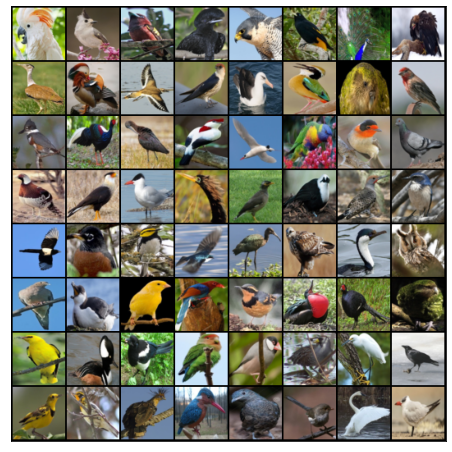

In [ ]:
for images, _ in birds_train_dataloader:
  display_images(images)
  break

In [ ]:
def save_samples(index, sample_images):
    fake_fname = 'generated-images-{}.png'.format(index)
    save_image(denormalize(sample_images[-64:]), os.path.join(".", fake_fname), nrow=8)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.input_size = input_size
        self.channel = 3
        self.kernal_size = 4
        self.stride = 2
        self.padding = 1
        self.bias = False
        self.negative_slope = 0.2

        self.model = nn.Sequential(
              #input size: (3,64,64)
              nn.Conv2d(self.channel, self.input_size, kernel_size=self.kernal_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(64),
              nn.LeakyReLU(self.negative_slope, inplace=True),

              #input size: (64,32,32)
              nn.Conv2d(64, 128, kernel_size=self.kernal_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(128),
              nn.LeakyReLU(self.negative_slope, inplace=True),

              #input size: (128,16,16)
              nn.Conv2d(128, 256, kernel_size=self.kernal_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(256),
              nn.LeakyReLU(self.negative_slope, inplace=True),

              #input size: (256,8,8)
              nn.Conv2d(256, 512, kernel_size=self.kernal_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(512),
              nn.LeakyReLU(self.negative_slope, inplace=True),

              #input size: (512,4,4)
              nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
              # output size: 1 x 1 x 1

              nn.Flatten(),
              nn.Sigmoid()
        )

    def forward(self, input_img):
        validity = self.model(input_img)
        return validity



In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size = 128):
        super().__init__()
        self.latent_size = latent_size
        self.kernal_size = 4
        self.stride = 2
        self.padding = 1
        self.bias = False

        self.model = nn.Sequential(

              #input size: (latent_size,1,1)
              nn.ConvTranspose2d(latent_size, 512, kernel_size=self.kernal_size, stride=1, padding=0, bias=self.bias),
              nn.BatchNorm2d(512),
              nn.ReLU(True),

              #input size: (512,4,4)
              nn.ConvTranspose2d(512, 256, kernel_size=self.kernal_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(256),
              nn.ReLU(True),

              #input size: (256,8,8)
              nn.ConvTranspose2d(256, 128, kernel_size=self.kernal_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(128),
              nn.ReLU(True),

              #input size: (128,16,16)
              nn.ConvTranspose2d(128, 64, kernel_size=self.kernal_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.BatchNorm2d(64),
              nn.ReLU(True),

              nn.ConvTranspose2d(64, 3, kernel_size=self.kernal_size, stride=self.stride, padding=self.padding, bias=self.bias),
              nn.Tanh()
              # output size: 3 x 64 x 64
        )

    def forward(self, input_img):
        input_img = self.model(input_img)
        return input_img




In [ ]:
ALL_IMAGES = []
class GAN(pl.LightningModule):

    def __init__(self, latent_size = 128,learning_rate = 0.0002,bias1 = 0.5,bias2 = 0.999,batch_size = 128):
        super().__init__()
        self.save_hyperparameters()

        # networks
        # data_shape = (channels, width, height)
        self.generator = Generator()
        self.discriminator = Discriminator(input_size=64)

        self.batch_size = batch_size
        self.latent_size = latent_size
        self.validation = torch.randn(self.batch_size, self.latent_size, 1, 1)

        # self.example_input_array = torch.zeros(2, self.hparams.latent_dim)

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, preds, targets):
        return F.binary_cross_entropy(preds, targets)

    def training_step(self, batch, batch_idx, optimizer_idx):
        real_images, _ = batch

        # train generator
        if optimizer_idx == 0:

            # Generate fake images
            fake_random_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)
            fake_random_noise = fake_random_noise.type_as(real_images)
            fake_images = self(fake_random_noise) #self.generator(latent)
            
            # Try to fool the discriminator
            preds = self.discriminator(fake_images)
            targets = torch.ones(self.batch_size, 1)
            targets = targets.type_as(real_images)
            
            loss = self.adversarial_loss(preds, targets)
            

            tqdm_dict = {'g_loss': loss}
            output = OrderedDict({
                'loss': loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output


        # train discriminator
        if optimizer_idx == 1:

            # Pass real images through discriminator
            real_preds = self.discriminator(real_images)
            real_targets = torch.ones(real_images.size(0), 1)
            real_targets = real_targets.type_as(real_images)
            real_loss = self.adversarial_loss(real_preds, real_targets)
            # real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            real_random_noise = torch.randn(self.batch_size, self.latent_size, 1, 1)
            real_random_noise = real_random_noise.type_as(real_images)
            fake_images = self(real_random_noise) #self.generator(latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1)
            fake_targets = fake_targets.type_as(real_images)
            fake_preds = self.discriminator(fake_images)
            fake_loss = self.adversarial_loss(fake_preds, fake_targets)
            # fake_score = torch.mean(fake_preds).item()

            # Update discriminator weights
            loss = real_loss + fake_loss
            #########
            tqdm_dict = {'d_loss': loss}
            output = OrderedDict({
                'loss': loss,
                'progress_bar': tqdm_dict,
                'log': tqdm_dict
            })
            return output


        

    def configure_optimizers(self):
        learning_rate = self.hparams.learning_rate
        bias1 = self.hparams.bias1
        bias2 = self.hparams.bias2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=learning_rate, betas=(bias1, bias2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate, betas=(bias1, bias2))
    
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        # import pdb;pdb.set_trace()
        z = self.validation.type_as(self.generator.model[0].weight)
        sample_imgs = self(z) #self.current_epoch
        ALL_IMAGES.append(sample_imgs.cpu())
        save_samples(self.current_epoch, sample_imgs)

In [ ]:
def on_epoch_end(self):
  z = self.validation.type_as(self.generator.model[0].weight)
  sample_imgs = self(z) 
  ALL_IMAGES.append(sample_imgs.cpu())
  save_samples(self.current_epoch, sample_imgs)

In [ ]:
%%time
model = GAN()
trainer = pl.Trainer( max_epochs=500, progress_bar_refresh_rate=25, gpus=1)#gpus=1,
trainer.fit(model, birds_train_dataloader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 3.8 M 
1 | discriminator | Discriminator | 2.8 M 
------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The {progress_bar:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The {log:dict keyword} was deprecated in 0.9.1 and will be removed in 1.0.0
Please use self.log(...) inside the lightningModule instead.

# log on a step or aggregate epoch metric to the logger and/or progress bar
# (inside LightningModule)
self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
  warnings.warn(*args, **kwargs)



CPU times: user 2h 50min 52s, sys: 1h 39min 40s, total: 4h 30min 32s
Wall time: 4h 39min 53s


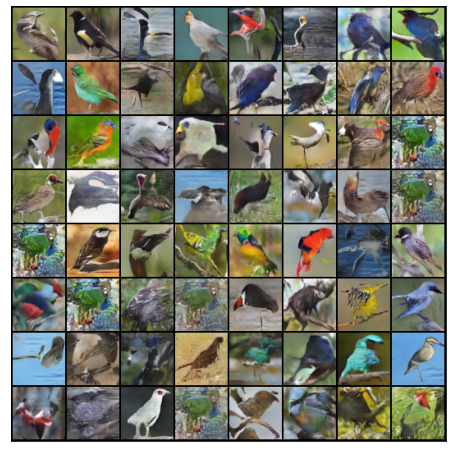

In [ ]:
display_images(ALL_IMAGES[-1])

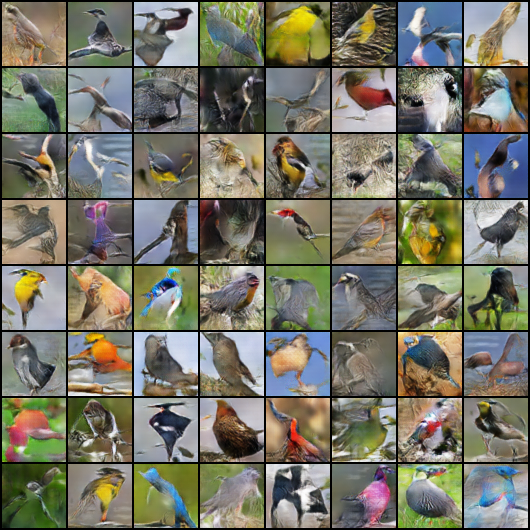

In [ ]:
from IPython.display import Image
Image('./generated-images-100.png')

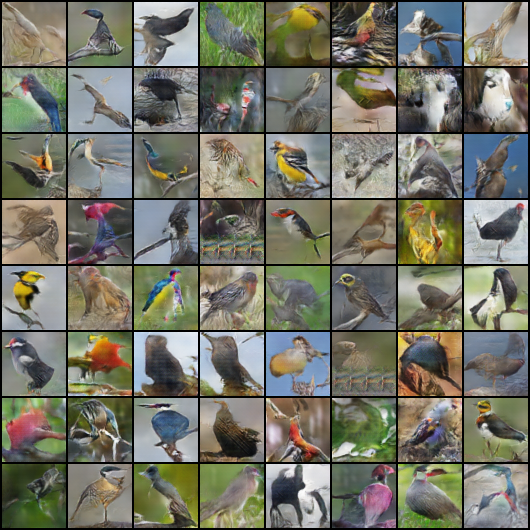

In [ ]:
from IPython.display import Image
Image('./generated-images-199.png')

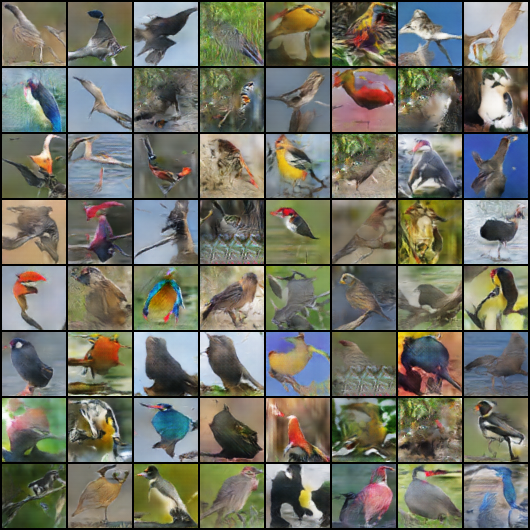

In [ ]:
from IPython.display import Image
Image('./generated-images-300.png')

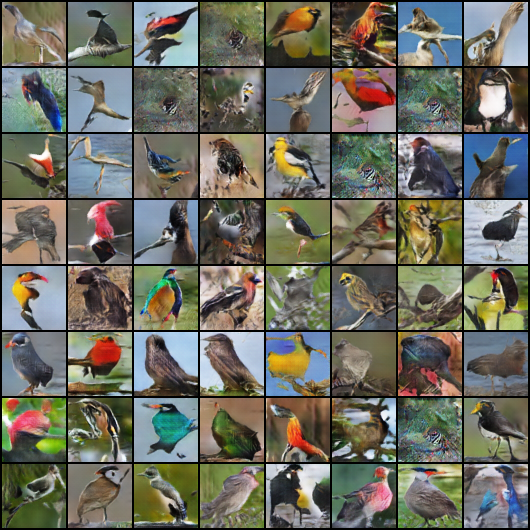

In [ ]:
from IPython.display import Image
Image('./generated-images-400.png')

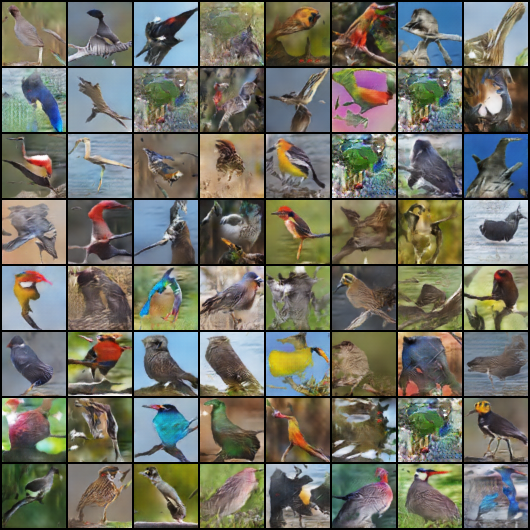

In [ ]:
from IPython.display import Image
Image('./generated-images-499.png')